In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from pathlib import Path
from typing import Union, List, Optional, Tuple


2023-07-03 07:35:19.604553: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 07:35:19.655870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helper functions

In [2]:
def exists(obj):
    return obj is not None


def write_image(image_path: Union[str, Path], image: np.ndarray):
    """Writes an RGB image using OpenCV."""
    if isinstance(image_path, Path):
        image_path = str(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = image.astype(np.uint8) if image.dtype == np.float32 else image
    cv2.imwrite(image_path, image)


def write_mask(mask_path: Union[str, Path], mask: np.ndarray):
    """Writes a binary mask using OpenCV."""
    assert_mask_is_binary(mask)
    if isinstance(mask_path, Path):
        mask_path = str(mask_path)
    mask = mask * 255.0 if mask.max() == 1 else mask
    mask = mask.astype(np.uint8) if mask.dtype == np.float32 else mask
    cv2.imwrite(mask_path, mask)


def read_image(image_path: Union[str, Path]) -> np.ndarray:
    """Reads an image from a path and converts it to RGB format."""
    if isinstance(image_path, Path):
        image_path = str(image_path)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return image.astype(np.float32)


def read_mask(mask_path: Union[str, Path]) -> np.ndarray:
    """Reads a mask from a path and transform it to binary."""
    if isinstance(mask_path, Path):
        mask_path = str(mask_path)
    mask = cv2.imread(mask_path, 0)
    if mask.max() == 255:
        mask = mask / 255.0
    assert_mask_is_binary(mask)
    return mask.astype(np.float32)


def assert_mask_is_binary(mask: np.ndarray):
    """Counts all the pixels different to zero and one to check if binary."""
    assert (
        np.count_nonzero((mask != 0) & (mask != 1)) == 0
    ), f"Mask is not binary. Unique values: {np.unique(mask)}"


def read_images_grid(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[np.ndarray]]:
    patches = []
    for i, patches_paths_row in enumerate(patches_paths):
        images_row = []
        for j, patch_path in enumerate(patches_paths_row):
            image = (
                read_image(patch_path)
                if exists(patch_path)
                else np.zeros((1024, 1024, 3))
            )
            images_row.append(image)
        patches.append(images_row)
    return patches


def crop_black_frames_from_image(img: np.ndarray) -> np.ndarray:
    positions = np.nonzero(img)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    return img[top:bottom, left:right]


def sort_paths_from_idxs(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[Union[str, Path]]]:
    """Creates a grid of paths from a list of paths based on their ids."""
    if isinstance(patches_paths[0], str):
        patches_paths = [Path(patch_path) for patch_path in patches_paths]
    idxs = [patch_path.stem.split("_")[-2:] for patch_path in patches_paths]
    idxs = [[int(i[0]), int(i[1])] for i in idxs]

    # Create the grid.
    (y_min, x_min), (y_max, x_max) = np.min(idxs, axis=0), np.max(idxs, axis=0)
    sorted_paths, missing_patches_idxs = [], []
    for j in range(y_max + 1):
        row_paths = []
        for i in range(x_max + 1):
            if [j, i] not in idxs:
                missing_patches_idxs.append([j, i])
                row_paths.append(None)
            else:
                row_paths.append(patches_paths[idxs.index([j, i])])
        sorted_paths.append(row_paths)

    return sorted_paths, missing_patches_idxs


def create_and_save_images_for_sample(
    reconstructed_sample_image_path: Union[str, Path],
    sample_patches_paths: List[Union[str, Path]],
    reconstructed_sample_mask_path: Optional[Union[str, Path]] = None,
    sample_mask_path: Optional[Union[str, Path]] = None,
):
    sorted_sample_patches_paths, _ = sort_paths_from_idxs(sample_patches_paths)
    sorted_sample_patches = read_images_grid(sorted_sample_patches_paths)
    reconstructed_sample_image = np.vstack(
        [np.hstack(row) for row in sorted_sample_patches]
    ).astype(np.float32)

    # Process the reconstructed image.
    reconstructed_sample_image = crop_black_frames_from_image(
        reconstructed_sample_image
    )
    reconstructed_sample_image = reconstructed_sample_image
    write_image(str(reconstructed_sample_image_path), reconstructed_sample_image)

    # Read and resize mask to cropped reconstructed image.
    if exists(sample_mask_path):
        sample_mask = read_mask(sample_mask_path)
        height, width = reconstructed_sample_image.shape[:2]
        resized_sample_mask = cv2.resize(
            sample_mask, (width, height), interpolation=cv2.INTER_NEAREST
        )
        write_mask(str(reconstructed_sample_mask_path), resized_sample_mask)


# Variables

In [3]:
dset_dir = Path("/data/histopathology/TCGA/")

patches_dir = dset_dir / "patches"
masks_dir = dset_dir / "masks"

# In the patches directory are more directories and in the masks directory are png files.
patches_dirs = sorted(patches_dir.iterdir())
masks_paths = sorted(masks_dir.iterdir())

mask_sample_ids = [mask_path.stem[:-5] for mask_path in masks_paths]
patches_sample_ids = [patch_dir.name for patch_dir in patches_dirs]
test_sample_ids = sorted(list(set(patches_sample_ids).difference(mask_sample_ids)))
train_sample_ids = sorted(list(set(patches_sample_ids).intersection(mask_sample_ids)))

print(f"Number of samples with masks: {len(train_sample_ids)} \n")
print(f"Samples ids without masks:", *test_sample_ids, sep="\n- ")


Number of samples with masks: 33 

Samples ids without masks:
- TCGA-99-8028-01Z-00-DX1.23de89b1-67f8-41fb-980a-010ea190d687
- TCGA-99-8032-01Z-00-DX1.7380b78f-ea25-43e0-ac90-194b5c6b1432
- TCGA-J2-8194-01Z-00-DX1.7700924D-B6AF-46A7-A7D7-B5C17A66C5F7
- TCGA-MP-A4TK-01Z-00-DX1.57494698-D9D9-4C04-AAB2-16616CCFDCC9
- TCGA-NJ-A55R-01Z-00-DX1.2E2B3642-4E1C-47DB-AF7B-988D586C0986


# Create the dataset

## 5Fold: Train and validation

In [6]:
target_dir = Path("/data/histopathology/TCGA/reconstructed")
column_names = [
    "sample_id",
    "source_patches_dir",
    "source_mask_path",
    "target_image_path",
    "target_mask_path",
]

# Do a KFold split to create a validation set.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idxs, val_idxs) in enumerate(kf.split(train_sample_ids)):
    kfold_train_sample_ids = np.array(train_sample_ids)[train_idxs]
    kfold_val_sample_ids = np.array(train_sample_ids)[val_idxs]

    fold_dir = target_dir / f"fold{i}"
    train_dir = fold_dir / "train"
    train_images_dir = train_dir / "images"
    train_masks_dir = train_dir / "masks"
    train_images_dir.mkdir(parents=True, exist_ok=True)
    train_masks_dir.mkdir(parents=True, exist_ok=True)
    train_fold_dict = {col: [] for col in column_names}
    for sample_id in tqdm(
        kfold_train_sample_ids, desc=f"Creating training images for fold {i}"
    ):
        # Read the sources patches and masks.
        sample_patches_paths = sorted((patches_dir / sample_id).iterdir())
        sample_mask_path = masks_dir / f"{sample_id}_mask.png"

        # Create the reconstructed images and masks.
        reconstructed_sample_image_path = (
            train_images_dir / f"{sample_id}_reconstructed.png"
        )
        reconstructed_sample_mask_path = (
            train_masks_dir / f"{sample_id}_reconstructed.png"
        )
        create_and_save_images_for_sample(
            reconstructed_sample_image_path,
            sample_patches_paths,
            reconstructed_sample_mask_path,
            sample_mask_path,
        )

        # Append to the fold dict.
        train_fold_dict["sample_id"].append(sample_id)
        train_fold_dict["source_patches_dir"].append(str(patches_dir / sample_id))
        train_fold_dict["source_mask_path"].append(str(sample_mask_path))
        train_fold_dict["target_image_path"].append(
            str(reconstructed_sample_image_path)
        )
        train_fold_dict["target_mask_path"].append(str(reconstructed_sample_mask_path))

    # Save the fold dicts as csv files.
    train_fold_df = pd.DataFrame(train_fold_dict)
    train_fold_df.to_csv(fold_dir / "train.csv", index=False)

    val_dir = fold_dir / "val"
    val_images_dir = val_dir / "images"
    val_masks_dir = val_dir / "masks"
    val_images_dir.mkdir(parents=True, exist_ok=True)
    val_masks_dir.mkdir(parents=True, exist_ok=True)
    val_fold_dict = {col: [] for col in column_names}
    for sample_id in tqdm(
        kfold_val_sample_ids, desc=f"Creating val images for fold {i}"
    ):
        # Read the sources patches and masks.
        sample_patches_paths = sorted((patches_dir / sample_id).iterdir())
        sample_mask_path = masks_dir / f"{sample_id}_mask.png"

        # Create the reconstructed images and masks.
        reconstructed_sample_image_path = (
            val_images_dir / f"{sample_id}_reconstructed.png"
        )
        reconstructed_sample_mask_path = (
            val_masks_dir / f"{sample_id}_reconstructed.png"
        )
        create_and_save_images_for_sample(
            reconstructed_sample_image_path,
            sample_patches_paths,
            reconstructed_sample_mask_path,
            sample_mask_path,
        )

        # Append to the fold dict.
        val_fold_dict["sample_id"].append(sample_id)
        val_fold_dict["source_patches_dir"].append(str(patches_dir / sample_id))
        val_fold_dict["source_mask_path"].append(str(sample_mask_path))
        val_fold_dict["target_image_path"].append(str(reconstructed_sample_image_path))
        val_fold_dict["target_mask_path"].append(str(reconstructed_sample_mask_path))

    # Save the fold dicts as csv files.
    val_fold_df = pd.DataFrame(val_fold_dict)
    val_fold_df.to_csv(fold_dir / "val.csv", index=False)


Creating training images for fold 0:   0%|          | 0/26 [00:00<?, ?it/s]

Creating val images for fold 0:   0%|          | 0/7 [00:00<?, ?it/s]

Creating training images for fold 1:   0%|          | 0/26 [00:00<?, ?it/s]

Creating val images for fold 1:   0%|          | 0/7 [00:00<?, ?it/s]

Creating training images for fold 2:   0%|          | 0/26 [00:00<?, ?it/s]

Creating val images for fold 2:   0%|          | 0/7 [00:00<?, ?it/s]

Creating training images for fold 3:   0%|          | 0/27 [00:00<?, ?it/s]

Creating val images for fold 3:   0%|          | 0/6 [00:00<?, ?it/s]

Creating training images for fold 4:   0%|          | 0/27 [00:00<?, ?it/s]

Creating val images for fold 4:   0%|          | 0/6 [00:00<?, ?it/s]

## Patch extraction for training

Function to extract patches from a given image

In [12]:
def extract_patches(image, patch_size, stride):
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i : i + patch_size, j : j + patch_size]
            patches.append(patch)
    return patches


For each fold, extract the patches from the reconstructed images and store them in a new "patches" directory

In [13]:
target_dir = Path("/data/histopathology/TCGA/reconstructed")

for i in range(5):
    fold_dir = target_dir / f"fold{i}"
    images_dir = fold_dir / "train" / "images"
    masks_dir = fold_dir / "train" / "masks"
    patches_dir = fold_dir / "train" / "patches"
    image_patches_dir = patches_dir / "images"
    mask_patches_dir = patches_dir / "masks"
    image_patches_dir.mkdir(parents=True, exist_ok=True)
    mask_patches_dir.mkdir(parents=True, exist_ok=True)

    sorted_images = sorted(images_dir.iterdir())
    for image_path in tqdm(
        sorted_images, desc=f"Extracting training patches for fold {i}"
    ):
        image = read_image(image_path)
        mask = read_mask(masks_dir / image_path.name)
        image_patches = extract_patches(image, 224, 56)
        mask_patches = extract_patches(mask, 224, 56)
        for j, (image_patch, mask_patch) in enumerate(zip(image_patches, mask_patches)):
            image_patch_path = image_patches_dir / f"{image_path.stem}_{j:04d}.png"
            mask_patch_path = mask_patches_dir / f"{image_path.stem}_{j:04d}.png"
            write_image(image_patch_path, image_patch)
            write_mask(str(mask_patch_path), mask_patch)

    images_dir = fold_dir / "val" / "images"
    masks_dir = fold_dir / "val" / "masks"
    patches_dir = fold_dir / "val" / "patches"
    image_patches_dir = patches_dir / "images"
    mask_patches_dir = patches_dir / "masks"
    image_patches_dir.mkdir(parents=True, exist_ok=True)
    mask_patches_dir.mkdir(parents=True, exist_ok=True)

    sorted_images = sorted(images_dir.iterdir())
    for image_path in tqdm(
        sorted_images, desc=f"Extracting validation patches for fold {i}"
    ):
        image = read_image(image_path)
        mask = read_mask(masks_dir / image_path.name)
        image_patches = extract_patches(image, 224, 56)
        mask_patches = extract_patches(mask, 224, 56)
        for j, (image_patch, mask_patch) in enumerate(zip(image_patches, mask_patches)):
            image_patch_path = image_patches_dir / f"{image_path.stem}_{j:04d}.png"
            mask_patch_path = mask_patches_dir / f"{image_path.stem}_{j:04d}.png"
            write_image(image_patch_path, image_patch)
            write_mask(str(mask_patch_path), mask_patch)


Extracting training patches for fold 0:   0%|          | 0/26 [00:00<?, ?it/s]

Extracting validation patches for fold 0:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting training patches for fold 1:   0%|          | 0/26 [00:00<?, ?it/s]

Extracting validation patches for fold 1:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting training patches for fold 2:   0%|          | 0/26 [00:00<?, ?it/s]

Extracting validation patches for fold 2:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting training patches for fold 3:   0%|          | 0/27 [00:00<?, ?it/s]

Extracting validation patches for fold 3:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting training patches for fold 4:   0%|          | 0/27 [00:00<?, ?it/s]

Extracting validation patches for fold 4:   0%|          | 0/6 [00:00<?, ?it/s]

## Test

In [14]:
target_dir = Path("/data/histopathology/TCGA/reconstructed")
dset_dir = Path("/data/histopathology/TCGA/")

patches_dir = dset_dir / "patches"
masks_dir = dset_dir / "masks"

# In the patches directory are more directories and in the masks directory are png files.
patches_dirs = sorted(patches_dir.iterdir())
masks_paths = sorted(masks_dir.iterdir())

column_names = [
    "sample_id",
    "source_patches_dir",
    "source_mask_path",
    "target_image_path",
    "target_mask_path",
]

test_dir = target_dir / "test"
test_images_dir = test_dir / "images"
test_masks_dir = test_dir / "masks"
test_images_dir.mkdir(parents=True, exist_ok=True)
test_masks_dir.mkdir(parents=True, exist_ok=True)
test_fold_dict = {col: [] for col in column_names}

for sample_id in tqdm(test_sample_ids, desc="Creating test images"):
    # Read the sources patches and masks.
    sample_patches_paths = sorted((patches_dir / sample_id).iterdir())
    sample_mask_path = masks_dir / f"{sample_id}_mask.png"
    assert not sample_mask_path.exists()

    # Create the reconstructed images and masks.
    reconstructed_sample_image_path = test_images_dir / f"{sample_id}_reconstructed.png"
    create_and_save_images_for_sample(
        reconstructed_sample_image_path,
        sample_patches_paths,
    )

    # Append to the fold dict.
    test_fold_dict["sample_id"].append(sample_id)
    test_fold_dict["source_patches_dir"].append(str(patches_dir / sample_id))
    test_fold_dict["source_mask_path"].append(None)
    test_fold_dict["target_image_path"].append(str(reconstructed_sample_image_path))
    test_fold_dict["target_mask_path"].append(None)

# Save the fold dicts as csv files.
test_fold_df = pd.DataFrame(test_fold_dict)
test_fold_df.to_csv(test_dir / "test.csv", index=False)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Creating test images:   0%|          | 0/5 [00:00<?, ?it/s]

# Create a TFRecord file

## Functions

In [4]:
def get_paths_from_directory(
    directory: Union[str, Path]
) -> Tuple[np.ndarray, np.ndarray]:
    """Get data from directory.

    Args:
        directory (Union[str, Path]): Directory to get data from.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of data and labels.
    """

    if isinstance(directory, str):
        directory = Path(directory)

    images_dir = directory / "images"
    labels_dir = directory / "masks"
    assert images_dir.is_dir() and labels_dir.is_dir()
    images_path = sorted(images_dir.iterdir())
    labels_path = sorted(labels_dir.iterdir())

    return images_path, labels_path


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    elif isinstance(value, str):
        value = value.encode("utf-8")
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    value = [value] if isinstance(value, int) else value
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(image, mask):
    feature = {
        "image": _bytes_feature(tf.io.serialize_tensor(image)),
        "image_shape": _int64_feature(list(image.shape)),
        "mask": _bytes_feature(tf.io.serialize_tensor(mask)),
        "mask_shape": _int64_feature(list(mask.shape) + [1]),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def shuffle_data_and_labels(data_paths, labels_paths, seed=2341):
    np.random.seed(seed)

    indices = np.arange(len(data_paths))
    np.random.shuffle(indices)

    data_paths = np.array(data_paths)[indices].tolist()
    labels_paths = np.array(labels_paths)[indices].tolist()

    return data_paths, labels_paths


## TFRecord

In [5]:
dset_dir = Path("/data/histopathology/TCGA/reconstructed/fold0")
train_dir = dset_dir / "train/patches"
val_dir = dset_dir / "val/patches"

data_paths, labels_paths = get_paths_from_directory(train_dir)

# Shuffle the data to avoid using shuffle_buffer to conserve memory.
np.random.seed(2341)
indices = np.arange(len(data_paths))
np.random.shuffle(indices)

data_paths = np.array(data_paths)[indices].tolist()
labels_paths = np.array(labels_paths)[indices].tolist()


In [ ]:
# Write the paths to a TFRecord file.
tfrecords_dir = Path().absolute().parent / "data"
tfrecords_dset_dir = tfrecords_dir / "TCGA_patches_224_56"
tfrecords_dset_dir.mkdir(exist_ok=True, parents=True)

for i in range(5):
    print("Creating the TFRecord for fold", i)

    # Source directories.
    dset_dir = Path(f"/data/histopathology/TCGA/reconstructed/fold{i}")
    train_dir = dset_dir / "train/patches"
    val_dir = dset_dir / "val/patches"
    train_data_paths, train_labels_paths = get_paths_from_directory(train_dir)
    train_data_paths, train_labels_paths = shuffle_data_and_labels(
        train_data_paths, train_labels_paths, seed=i
    )
    val_data_paths, val_labels_paths = get_paths_from_directory(val_dir)
    val_data_paths, val_labels_paths = shuffle_data_and_labels(
        val_data_paths, val_labels_paths, seed=i
    )

    # TFRecords creation.
    train_tfrecord_path = str(tfrecords_dset_dir / f"fold{i}_train.tfrecord")
    with tf.io.TFRecordWriter(train_tfrecord_path) as writer:
        for idx, (data_path, label_path) in enumerate(
            zip(train_data_paths, train_labels_paths)
        ):
            image = read_image(data_path)
            mask = read_mask(label_path)
            serialized_features = serialize_example(image, mask)
            writer.write(serialized_features)

    val_tfrecord_path = str(tfrecords_dset_dir / f"fold{i}_val.tfrecord")
    with tf.io.TFRecordWriter(val_tfrecord_path) as writer:
        for idx, (data_path, label_path) in enumerate(
            zip(val_data_paths, val_labels_paths)
        ):
            image = read_image(data_path)
            mask = read_mask(label_path)
            serialized_features = serialize_example(image, mask)
            writer.write(serialized_features)


Creating the TFRecord for fold 0


2023-07-03 07:35:59.135516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2023-07-03 07:35:59.135555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 1660b6c49a51
2023-07-03 07:35:59.135561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 1660b6c49a51
2023-07-03 07:35:59.135708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-07-03 07:35:59.135729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17


2023-07-02 18:34:24.327459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


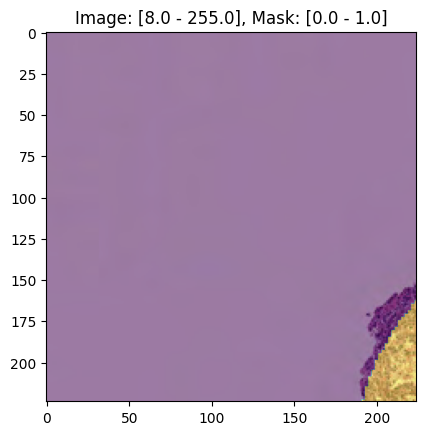

In [60]:
feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "image_shape": tf.io.FixedLenFeature([3], tf.int64),
    "mask": tf.io.FixedLenFeature([], tf.string),
    "mask_shape": tf.io.FixedLenFeature([3], tf.int64),
}


def parse_example(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_desc)
    image = tf.io.parse_tensor(example["image"], tf.float32)
    image = tf.reshape(image, example["image_shape"])
    mask = tf.io.parse_tensor(example["mask"], tf.float32)
    mask = tf.reshape(mask, example["mask_shape"])
    return image, mask


tfrecord = tf.data.TFRecordDataset(
    "/home/sangohe/projects/pathology/data/TCGA_patches_224_56/fold0_train.tfrecord"
)
dset = tfrecord.map(parse_example)

for image, mask in dset:
    if np.count_nonzero(mask.numpy()) > 0:
        break

plt.imshow(image.numpy().astype(np.uint8))
plt.imshow(mask.numpy().astype(np.uint8), alpha=0.5)
plt.title(
    f"Image: [{image.numpy().min()} - {image.numpy().max()}], "
    f"Mask: [{mask.numpy().min()} - {mask.numpy().max()}]"
)
plt.show()


# Functions to rename all the paths

In [ ]:
def rename_path(path):
    patch_num = path.stem.split("_")[-1]
    new_filename = path.name.replace(f"{patch_num}.png", f"{int(patch_num):04d}.png")
    path.rename(path.parent / new_filename)
    return path.parent / new_filename


def rename_paths_from_dir(dir_):
    masks_patches_paths = sorted(dir_.iterdir())
    for mask_patch_path in masks_patches_paths:
        rename_path(mask_patch_path)
        

for i in range(5):
    pass

    dset_dir = Path(f"/data/histopathology/TCGA/reconstructed/fold{i}/")
    print(dset_dir)
    train_csv_path = dset_dir / "train.csv"
    val_csv_path = dset_dir / "val.csv"

    masks_dir = dset_dir / "train" / "patches" / "masks"
    images_dir = dset_dir / "train" / "patches" / "images"
    assert masks_dir.is_dir() and images_dir.is_dir()

    rename_paths_from_dir(images_dir)
    rename_paths_from_dir(masks_dir)
